## Header

### Imports

In [ ]:
%matplotlib inline
#%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.image import imread, imsave
import numpy as np
import cv2
import h5py
import tifffile
import tqdm
import sys
import time
import IPython
import torch
import torch.nn as nn
import torch.nn.functional as fn
import numpy as np
import math
import os
import tqdm
import gc
from scipy.optimize import curve_fit
from multiprocessing import Pool


device = torch.device('cuda:0')


### Funcs

In [ ]:


def eprint(*args, **kwargs):
    print(*args, file=sys.stderr, **kwargs)


def loadImage(imageName, expectedShape=None) :
    if not imageName:
        return None
    #imdata = imread(imageName).astype(np.float32)
    imdata = tifffile.imread(imageName).astype(np.float32)
    if len(imdata.shape) == 3 :
        imdata = np.mean(imdata[:,:,0:3], 2)
    if not expectedShape is None  and  imdata.shape != expectedShape :
        raise Exception(f"Dimensions of the input image \"{imageName}\" {imdata.shape} "
                        f"do not match expected shape {expectedShape}.")
    return imdata



def plotData(dataY, rangeY=None, dataYR=None, rangeYR=None,
             dataX=None, rangeX=None, rangeP=None,
             figsize=(16,8), saveTo=None, show=True):

    if type(dataY) is np.ndarray :
        plotData((dataY,), rangeY=rangeY, dataYR=dataYR, rangeYR=rangeYR,
             dataX=dataX, rangeX=rangeX, rangeP=rangeP,
             figsize=figsize, saveTo=saveTo, show=show)
        return
    if type(dataYR) is np.ndarray :
        plotData(dataY, rangeY=rangeY, dataYR=(dataYR,), rangeYR=rangeYR,
             dataX=dataX, rangeX=rangeX, rangeP=rangeP,
             figsize=figsize, saveTo=saveTo, show=show)
        return
    if type(dataY) is not tuple and type(dataY) is not list:
        eprint(f"Unknown data type to plot: {type(dataY)}.")
        return
    if type(dataYR) is not tuple and dataYR is not None:
        eprint(f"Unknown data type to plot: {type(dataYR)}.")
        return

    last = min( len(data) for data in dataY )
    if dataYR is not None:
        last = min( last,  min( len(data) for data in dataYR ) )
    if dataX is not None:
        last = min(last, len(dataX))
    if rangeP is None :
        rangeP = (0,last)
    elif type(rangeP) is int :
        rangeP = (0,rangeP) if rangeP > 0 else (-rangeP,last)
    elif type(rangeP) is tuple :
        rangeP = ( 0    if rangeP[0] is None else rangeP[0],
                   last if rangeP[1] is None else rangeP[1],)
    else :
        eprint(f"Bad data type on plotData input rangeP: {type(rangeP)}")
        raise Exception(f"Bug in the code.")
    rangeP = np.s_[ max(0, rangeP[0]) : min(last, rangeP[1]) ]
    if dataX is None :
        dataX = np.arange(rangeP.start, rangeP.stop)

    plt.style.use('default')
    plt.style.use('dark_background')
    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.xaxis.grid(True, 'both', linestyle='dotted')
    if rangeX is not None :
        ax1.set_xlim(rangeX)
    else :
        ax1.set_xlim(rangeP.start,rangeP.stop-1)

    ax1.yaxis.grid(True, 'both', linestyle='dotted')
    nofPlots = len(dataY)
    if rangeY is not None:
        ax1.set_ylim(rangeY)
    colors = [ matplotlib.colors.hsv_to_rgb((hv/nofPlots, 1, 1)) for hv in range(nofPlots) ]
    for idx , data in enumerate(dataY):
        ax1.plot(dataX, data[rangeP], linestyle='-',  color=colors[idx])

    if dataYR is not None : # right Y axis
        ax2 = ax1.twinx()
        ax2.yaxis.grid(True, 'both', linestyle='dotted')
        nofPlots = len(dataYR)
        if rangeYR is not None:
            ax2.set_ylim(rangeYR)
        colors = [ matplotlib.colors.hsv_to_rgb((hv/nofPlots, 1, 1)) for hv in range(nofPlots) ]
        for idx , data in enumerate(dataYR):
            ax2.plot(dataX, data[rangeP], linestyle='dashed',  color=colors[idx])

    if saveTo:
        fig.savefig(saveTo)
    if not show:
        plt.close(fig)
    else :
        plt.show()


def plotImage(image) :
    plt.imshow(image, cmap='gray')
    plt.axis("off")
    plt.show()


def plotImages(images) :
    for i, img in enumerate(images) :
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.axis("off")
    plt.show()



### Read input

In [ ]:
inputString = "test/out_AM_sft.hdf:/data"
maskString = "test/out_AM_mask.tif"
bgString = None
dfString = None

def getData(inputString):
    sampleHDF = inputString.split(':')
    if len(sampleHDF) != 2 :
        raise Exception(f"String \"{inputString}\" does not represent an HDF5 format \"fileName:container\".")
    try :
        trgH5F =  h5py.File(sampleHDF[0],'r')
    except :
        raise Exception(f"Failed to open HDF file '{sampleHDF[0]}'.")
    if  sampleHDF[1] not in trgH5F.keys():
        raise Exception(f"No dataset '{sampleHDF[1]}' in input file {sampleHDF[0]}.")
    data = trgH5F[sampleHDF[1]]
    if not data.size :
        raise Exception(f"Container \"{inputString}\" is zero size.")
    sh = data.shape
    if len(sh) != 3 :
        raise Exception(f"Dimensions of the container \"{inputString}\" is not 3: {sh}.")
    return data

data = getData(inputString)
dataN = np.empty(data.shape, dtype=np.float32)
data.read_direct(dataN)
dsh = data.shape[1:]
nofF = data.shape[0]

maskImage = loadImage(maskString, dsh) if maskString else np.ones(dsh)
maskImage /= maskImage.max()

kernelImage = loadImage("ball.tif")
kernel = torch.tensor(kernelImage, device=device).unsqueeze(0).unsqueeze(0)
ksh = kernel.shape
st, mn = torch.std_mean(kernel)
kernel = ( kernel - mn ) / st
kernelBin = torch.where(kernel>0, 1, 0).to(torch.float32).to(device)

dfImage = loadImage(dfString, dsh) if dfString else np.zeros(dsh)
dfImage = np.where(maskImage == 1, dfImage, 0)
bgImage = loadImage(bgString, dsh) if bgString else np.ones(dsh)
bgImage = np.where(maskImage == 1, bgImage, 1)
bgImage -= dfImage
bgImage = np.where(bgImage > 0, bgImage, 1)

def getFrame(frame) :
    return np.where(maskImage == 1, ( data[frame,...] - dfImage ) / bgImage, 0 )


## Select ROI

In [ ]:

def selectVisually() :


    def getFrame(frame) :
        return np.where(maskImage == 1, data[frame,...], 0 )

    currentIdx = 0
    currentFrame = None
    roi = None
    currentPos = (0,0)
    thresholds = [0,100]
    clip = [0,0]
    currentMatch = None

    def onMouse(event, x, y, flags, *userdata) :
        global roi, currentPos
        if currentFrame is None:
            return
        currentPos = (x,y)
        if  event == cv2.EVENT_RBUTTONDOWN:
            roi = (x,y, None, None)
            updateFrame()
        elif event == cv2.EVENT_RBUTTONUP and not roi is None:
            if currentPos == (roi[0], roi[1]) :
                roi = None
            elif roi[2] is None:
                x = 0 if x < 0 else currentFrame.shape[1]-1 if x >= currentFrame.shape[1] else x
                y = 0 if y < 0 else currentFrame.shape[0]-1 if y >= currentFrame.shape[0] else y
                roi = ( min(roi[0],x), min(roi[1],y), abs(roi[0]-x), abs(roi[1]-y) )
            updateFrame()
        elif event == cv2.EVENT_MOUSEMOVE and flags & cv2.EVENT_FLAG_RBUTTON :
            updateFrame()


    def updateFrame(index = None) :
        global currentIdx, currentFrame
        if not index is None:
            currentIdx = index
            currentFrame = getFrame(index)
            cv2.setTrackbarPos(frameTrackbarName, windowName, index)
        global clip
        if currentFrame is None :
            return
        minV = currentFrame.min()
        maxV = currentFrame.max()
        # here I use second to the max value to avoid special values in some detectors
        maxV =  np.where(currentFrame == maxV, 0, currentFrame ).max()
        delta = maxV - minV
        clip[0] = minV + delta * thresholds[0] / 100
        clip[1] = maxV - delta * (1 - thresholds[1] / 100)
        if (clip[1] - clip[0]) < delta / 100 :
            shImage = np.where(currentFrame < clip[0], 0.0, 1.0)
            clip[1] = clip[0] + delta / 100
        else :
            shImage = ( np.clip(currentFrame, a_min=clip[0], a_max=clip[1]) - clip[0] ) / \
                        ( clip[1]-clip[0] if clip[1] != clip[0] else 1.0)
        shImage = np.repeat( np.expand_dims(shImage, 2), 3, axis=2 )
        if not roi is None:
            plotRoi = roi
            if roi[2] is None :
                plotRoi = (min(roi[0],currentPos[0]), min(roi[1],currentPos[1]),
                           abs(roi[0]-currentPos[0]), abs(roi[1]-currentPos[1]) )
            cv2.rectangle(shImage, plotRoi, color=(0,0,255), thickness=2)
        if not currentMatch is None:
            cv2.rectangle(shImage, currentMatch, color=(0,255,255), thickness=2)
        cv2.imshow(windowName, shImage)
        return True

    def showImage(*args):
        global currentFrame, currentIdx, currentMatch
        currentMatch = None
        currentIdx = args[0]
        currentFrame = getFrame(currentIdx)
        updateFrame()

    def updateThresholds():
        updateFrame()
        cv2.setTrackbarPos(loThresholdTrackbarName, windowName, thresholds[0])
        cv2.setTrackbarPos(hiThresholdTrackbarName, windowName, thresholds[1])

    def onLoThreshold(*args):
        thresholds[0] = args[0]
        if thresholds[1] < thresholds[0] :
            thresholds[1] = thresholds[0]
        updateThresholds()

    def onHiThreshold(*args):
        thresholds[1] = args[0]
        if thresholds[1] < thresholds[0] :
            thresholds[0] = thresholds[1]
        updateThresholds()


    windowName = "tracker"
    cv2.namedWindow(windowName, cv2.WINDOW_GUI_NORMAL)
    cv2.setWindowProperty(windowName, cv2.WND_PROP_TOPMOST, 1)
    cv2.setMouseCallback(windowName, onMouse)
    frameTrackbarName = "Frame"
    cv2.createTrackbar(frameTrackbarName, windowName, 0, nofF, showImage)
    loThresholdTrackbarName = "Lo threshold"
    cv2.createTrackbar(loThresholdTrackbarName, windowName, 0, 100, onLoThreshold)
    hiThresholdTrackbarName = "Hi threshold"
    cv2.createTrackbar(hiThresholdTrackbarName, windowName, 100, 100, onHiThreshold)
    onLoThreshold((0))
    onHiThreshold((100))

    def backToWindow() :
        showImage(currentIdx)
        while True :
            c = cv2.waitKey(0)
            if c == 27 : # Esc
                roi = None
                updateFrame()
            elif c == 32 : #space
                return True
            elif c == 225 or c == 233: #modifiers
                continue
            else :
                print(c)
                #cv2.destroyAllWindows()
                return False



## Track

In [ ]:
def removeBorders(img, mask) :

  sh = img.shape
  # BCT ONLY: the ball is never in the upper part of the image:
  #mask[:sh[0]//4,:] = 0

  def cleaLine(ln, ms, pos) :
    str = 0 if pos else -1
    mul = 1 if pos else -1
    idx = str
    prev = ln[idx]+1
    lnl = ln.shape[0]
    upcounter = 0
    while abs(idx) < lnl+abs(str)-1 :
      if ms[idx] == 0.0 :
        prev = ln[idx+mul]
      elif ln[idx] > prev :
        upcounter += 1
        if upcounter > 1 :
          break
        else :
          ms[idx] = 0
      else :
        upcounter = 0
        ms[idx] = 0
        prev = ln[idx]
      idx += mul

  for idy in range(sh[0]) :
    ln = img[idy,...]
    ms = mask[idy,...]
    cleaLine(ln, ms, True)
    cleaLine(ln, ms, False)
  for idx in range(sh[1]) :
    ln = img[...,idx]
    ms = mask[...,idx]
    cleaLine(ln, ms, True)
    cleaLine(ln, ms, False)



maskCorr = None
def getPos(img) :
  borderMask = maskCorr.copy()
  removeBorders(img, borderMask)
  img *= borderMask
  return np.array(np.unravel_index(np.argmax(img), img.shape))


def trackIt() :
    global maskCorr

    def normalize(ten, msk) :
        maskSum = torch.count_nonzero(msk)
        ten *= msk
        mn = ten.sum(dim=(-2,-1)).view(-1,1,1,1) / maskSum
        ten -= mn
        ten *= msk
        st = ten.norm(p=2, dim=(-2,-1)).view(-1,1,1,1) / maskSum
        ten /= st
        return ten

    torch.no_grad()
    maskPad = torch.zeros( (1, 1, dsh[-2] + 2*ksh[-2] - 2, dsh[-1] + 2*ksh[-1] - 2 ) )
    maskPad[..., ksh[-2]-1 : -ksh[-2]+1, ksh[-1]-1 : -ksh[-1]+1 ] = torch.from_numpy(maskImage).unsqueeze(0).unsqueeze(0)
    maskPad = maskPad.to(device)
    kernel4mask = torch.ones_like(kernel, device=device)
    maskCount = fn.conv2d(maskPad, kernel4mask)
    maskCount = torch.where(maskCount>1, maskCount, 1)
    maskBall = fn.conv2d(maskPad, (1-kernelBin))
    minArea = math.prod(ksh) // 56
    maskCorr = torch.where( maskBall > minArea, 1, 0).squeeze().cpu().numpy()

    #maskCorr = fn.conv2d(maskPad, kernel4mask)
    #maskCorr = torch.where(maskCorr<minArea, 0, 1/maskCorr)

    results=torch.empty( (0,2), device=device )
    resultsNP = np.empty((0,2))
    btPerIm = 4 * ( math.prod(maskPad.shape) + math.prod(maskImage.shape) )
    startIndex=0
    pbar = tqdm.tqdm(total=nofF)
    while True :
        gc.collect()
        torch.cuda.empty_cache()
        maxNofF = int ( 0.5   * torch.cuda.mem_get_info(device)[0] / btPerIm ) # 0.9 for contingency
        #maxNofF = 10
        stopIndex=min(startIndex+maxNofF, nofF)
        fRange = np.s_[startIndex:stopIndex]
        nofR = stopIndex-startIndex
        dataPad = torch.zeros( (nofR, 1, dsh[-2] + 2*ksh[-2] - 2, dsh[-1] + 2*ksh[-1] - 2 ) )
        dataPad[ ... , ksh[-2]-1 : -ksh[-2]+1, ksh[-1]-1 : -ksh[-1]+1 ] = \
            torch.from_numpy(dataN[fRange,...]).unsqueeze(1)
        dataPad = dataPad.to(device)
        dataPad = normalize(dataPad, maskPad)
        dataCorr = fn.conv2d(dataPad, kernel) / maskCount
        dataNP = dataCorr.cpu().numpy()
        dataTH = [ dataNP[cursl,0,...] for cursl in range(nofR) ]
        with Pool() as p:
            resultsR = np.array(p.map(getPos, dataTH))
            resultsNP = np.concatenate((resultsNP,resultsR),axis=0)
        #for cursl in range(nofR) :
        #  borderMask = maskCorr.copy()
        #  dataToProc = dataCorr[cursl,0,...].cpu().numpy()
        #  removeBorders(dataToProc, borderMask)
        #  dataCorr[cursl,0,...] *= torch.from_numpy(borderMask).to(device)
        #  pbar.update(1)
        #dataCorrFlat = dataCorr.view(dataCorr.shape[0],-1)
        #flatIndeces = dataCorrFlat.argmax(dim=-1)
        #resultsR = torch.stack([flatIndeces // dataCorr.shape[-1], flatIndeces % dataCorr.shape[-1]], -1)
        #results = torch.cat((results,resultsR),dim=0)

        pbar.update(nofR)
        startIndex = stopIndex
        if stopIndex >= nofF:
            break

    return resultsNP

trackResultsNP = trackIt()

#trackResults = trackIt()
#
#frameNumbers = np.expand_dims( np.linspace(0, nofF-1, nofF), 1)
#trackResultsX = np.concatenate((trackResults.cpu().numpy(), frameNumbers), axis=1)



## Plot

In [ ]:
%matplotlib inline
plotData(trackResultsNP[:,1], dataYR=trackResultsNP[:,0])


## Analyze

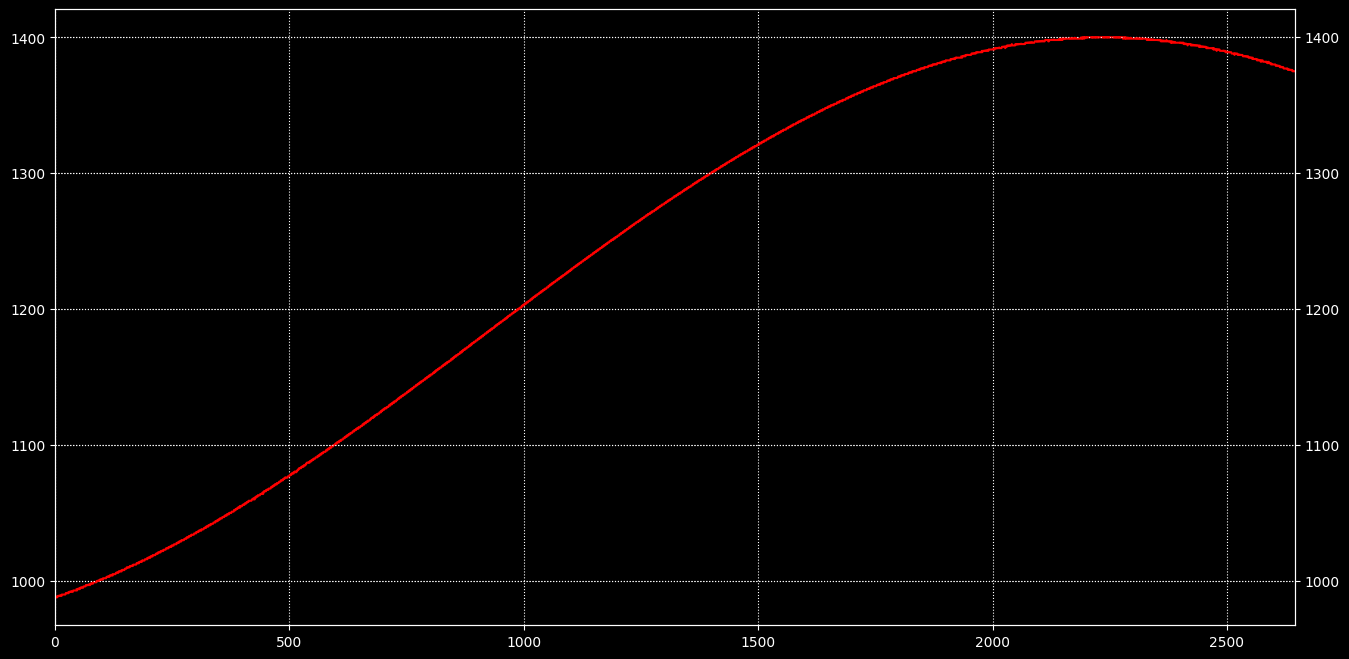

KeyboardInterrupt: 

In [ ]:
%matplotlib inline
def fit_as_sin(dat, xdat, xxdat=None) :

    def sin_func(x, a, b, c, d):
        return a + b * np.sin(c*x+d)

    xsize = xdat[-1]-xdat[0]
    x_norm = xdat / xsize
    delta = dat.max() - dat.min()
    if delta == 0 :
        return dat
    meanDat = dat.mean()
    dat_norm = (dat - meanDat) / delta # normalize for fitting
    popt, _ = curve_fit(sin_func, x_norm, dat_norm,
                        #p0 = [0, 0, math.pi, 0],
                        bounds=([-1 , 0, 0,         0],
                                [ 1 , 1, 2*math.pi, 2*math.pi]))
    dat_fit = meanDat + delta * sin_func(x_norm if xxdat is None else xxdat / xsize , *popt)
    popt[0] = meanDat + delta * popt[0]
    popt[1] *= delta
    return dat_fit, popt


# first stage of cleaning: based on Y position which should not change more than 3 pixels between frames
def firstStageClean(rawRes) :
    toRet = np.empty((0,3))
    for curF in range(1,rawRes.shape[0]-1) :
        if  abs(rawRes[curF,0]-rawRes[curF-1,0]) <= 3 \
        and abs(rawRes[curF,0]-rawRes[curF+1,0]) <= 3 :
            toRet = np.concatenate((toRet,rawRes[[curF],:]),axis=0)
    if  abs(rawRes[0,0]-toRet[0,0]) <= 2 :
        toRet = np.concatenate((rawRes[[0],:],toRet),axis=0)
    if  abs(rawRes[-1,0]-toRet[-1,0]) <= 2 :
        toRet = np.concatenate((toRet,rawRes[[-1],:]),axis=0)
    return toRet

frameNumbers = np.expand_dims( np.linspace(0, nofF-1, nofF), 1)
trackResultsX = np.concatenate((trackResultsNP, frameNumbers), axis=1)
cleanResults = firstStageClean(trackResultsX)


# second stage of cleaning: based on Y position which should not change more than 6 pixels away from median
def secondStageClean(rawRes) :
    med = np.median(rawRes[:,0])
    toRet = np.empty((0,3))
    for curF in range(rawRes.shape[0]) :
        if  abs(rawRes[curF,0]-med) <= 6 :
            toRet = np.concatenate((toRet,rawRes[[curF],:]),axis=0)
    return toRet

cleanResults = secondStageClean(cleanResults)


# third stage of cleaning: based on both X and Y tracks,
# which should not be more than 3 pixels away from sin-fitted curves
def thirdStageClean(rawRes, fit) :
    toRet = np.empty((0,3))
    for curF in range(rawRes.shape[0]) :
        if  abs( fit[curF,0] - rawRes[curF,0] ) <= 3 \
        and abs( fit[curF,1] - rawRes[curF,1] ) <= 3 :
            toRet = np.concatenate((toRet,rawRes[[curF],:]),axis=0)
    return toRet
res_fit0, _ = fit_as_sin(cleanResults[:,0], cleanResults[:,-1], frameNumbers)
res_fit1, _ = fit_as_sin(cleanResults[:,1], cleanResults[:,-1], frameNumbers)
res_fit = np.concatenate((res_fit0, res_fit1), axis=1) ###
cleanResults = thirdStageClean(trackResultsX, res_fit)



# fill the gaps
def fillCleaned(rawRes, frameNumbers) :
    inter0 = np.interp(frameNumbers, rawRes[:,-1], rawRes[:,0])
    inter1 = np.interp(frameNumbers, rawRes[:,-1], rawRes[:,1])
    filled = np.concatenate((inter0, inter1, frameNumbers), axis=1) ###
    return filled

posResults = fillCleaned(cleanResults, frameNumbers)
#plotData( finalResults[:,0], dataYR=finalResults[:,1] , dataX=finalResults[:,-1])

# make shifts from positions
shiftResults = posResults.copy()
shiftResults[:,0] -= np.round(np.mean(shiftResults[:,0]))
shiftResults[:,1] = np.round( shiftResults[:,1] - res_fit1[:,0] )

def shiftsClean(rawRes) :
    while True :
        interim = rawRes.copy()
        somethingChanged = False
        for curF in range(1,rawRes.shape[0]-1) :
            if rawRes[curF-1] == rawRes[curF+1] :
                if rawRes[curF-1] != rawRes[curF] :
                    interim[curF] = rawRes[curF-1]
                    somethingChanged = True
        if somethingChanged :
            rawRes[()] = interim
        else:
            break
    if rawRes[1] == rawRes[2] :
        rawRes[0] = rawRes[1]
    if rawRes[-2] == rawRes[-3] :
        rawRes[-1] = rawRes[-2]
    return rawRes

shiftsClean(shiftResults[:,0])
shiftResults[:,0] -= shiftResults[:,0].min()
shiftsClean(shiftResults[:,1])
shiftResults[:,1] -= shiftResults[:,1].min()


plotData( (shiftResults[:,0], shiftResults[:,1]), dataYR=(posResults[:,0], posResults[:,1]))

allResults = np.concatenate((shiftResults[:,:2], posResults[:,:2]), axis=1)

plotData( (allResults[:,0], allResults[:,1]), dataYR=(allResults[:,2], allResults[:,3]))







## Save

In [ ]:
outAr = np.stack((x_final,y_final),axis=1)
np.savetxt('test.txt', outAr)